# Predictive maintenece

### Main task

The dataset consists of 10 000 data points stored as rows with 14 features in columns:

UID: unique identifier ranging from 1 to 10000;

Product ID: consisting of a letter L, M, or H for low (60% of all products), medium (30%) and high (10%) as product quality variants and a variant-specific serial number;

Air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K;

Process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K;

Rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise;

Torque [Nm]: torque values are normally distributed around 40 Nm with a standard deviation of 10 Nm and no negative values;

Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process;

Machine failure: label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true. The machine failure consists of five independent failure modes:

Tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins;

Heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm;

Power failure (PWF):the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails;

Overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain;

Random failures (RNF):each process has a chance of 0,1 % to fail regardless of its process parameters. If at least one of the above failure modes is true, the process fails and the ’machine failure’ label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

### Exploratory data analysis

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV




In [3]:
data = pd.read_csv('/Users/mikkelpedersen/Desktop/project vs studio/Predictive_maintenece/predictive_maintenance.csv')

n = data.shape[0]

# Cheks the stucture
print('Features non-null values and data type:')
data.info()

# Checks if any duplicates exist 
print('Checks the data sturcture of the DataFrame: ', 
      data['Product ID'].unique().shape[0]!=n)

Features non-null values and data type:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
Checks the data sturcture of the DataFrame:  False


In [4]:
# Set numeric columns dtype to float
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')
# Rename features
data.rename(mapper={'Air temperature [K]': 'Air temperature',
                    'Process temperature [K]': 'Process temperature',
                    'Rotational speed [rpm]': 'Rotational speed',
                    'Torque [Nm]': 'Torque',
                    'Tool wear [min]': 'Tool wear'}, axis=1, inplace=True)

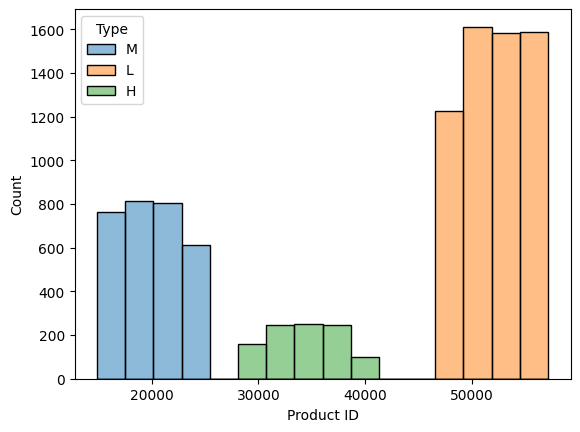

In [5]:
# Fjerner den første karakter og laver den til numeric
data['Product ID'] = data['Product ID'].apply(lambda x: x[1:])
data['Product ID'] = pd.to_numeric(data['Product ID'])

#Hist plot med de tre maskiner
sns.histplot(data=data, x='Product ID', hue='Type')
plt.show()
# Shows the number of sequences

In [6]:
# Laver en kopi af Data og dropper kolonnerne 'Product ID', 'UDI'
pm = data.copy()
pm.drop(columns=['Product ID', 'UDI'], inplace=True)


for col in pm.columns:
    if pm[col].dtypes == 'float64':
        pm[col] = pm[col].round(1)

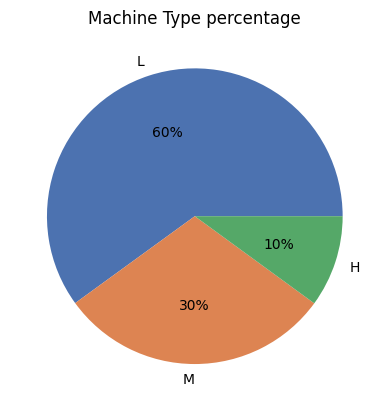

In [7]:
# Visualisering af den procentvise fordeling af maskinerne 

value = data['Type'].value_counts()
type_percentage = 100*value/data.shape[0]
labels = type_percentage.index.array
x = type_percentage.array

plt.pie(x, labels=labels, colors=sns.color_palette('deep')[0:3], autopct='%.0f%%')
plt.title('Machine Type percentage')
plt.show()

First, we use the pandas function loc[] to locate rows where the column 'Failure Type' is equal to 'Random Failures'.

Next, we use loc[] again to extract the target column values for the rows identified in step 1.

In [8]:
# laver en liste af features og target navne
features = [col for col in pm.columns
            if pm[col].dtype=='float64' or col =='Type']
target = ['Target','Failure Type']
# Del af dataen hvor RNF=1
idx_RNF = pm.loc[pm['Failure Type']=='Random Failures'].index
pm.loc[idx_RNF,target]

,Target,Failure Type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


In [9]:
first_drop = pm.loc[idx_RNF, target].shape[0]
print('Number of observations where RNF=1 but Machine failure=0:',first_drop)

pm.drop(index=idx_RNF, inplace=True)

Number of observations where RNF=1 but Machine failure=0: 18


In [10]:
# Andel af dataen hvor maskine fejl = 1, men der ikke er specificeret nogel grund 
idx_ambiguous = pm.loc[(pm['Target'] == 1) &
                       (pm['Failure Type'] == 'No Failure')].index
second_drop = pm.loc[idx_ambiguous].shape[0]
print('Number of ambiguous observations:', second_drop)
display(pm.loc[idx_ambiguous,target])
pm.drop(index=idx_ambiguous, inplace=True)

Number of ambiguous observations: 9


,Target,Failure Type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


In [11]:
print("global percantage of removed observations: ",
      (100*(first_drop+second_drop)/n))
pm.reset_index(drop=True, inplace=True)   # Reset index
n = pm.shape[0]

global percantage of removed observations:  0.27


In [12]:
pm.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target
count,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000,9973.000000
mean,300.003259,310.004031,1538.893212,39.978993,107.921087,0.033089
std,2.000548,1.483692,179.412171,9.966805,63.649152,0.178879
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.700000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


axs[j//3, j-3*(j//3)]: This is the Axes object on which the histogram will be drawn. axs is a 2D array of Axes objects created by the seaborn FacetGrid. j//3 is the row index, and j-3*(j//3) is the column index. This means that the histogram will be drawn in a subplot based on the j value.

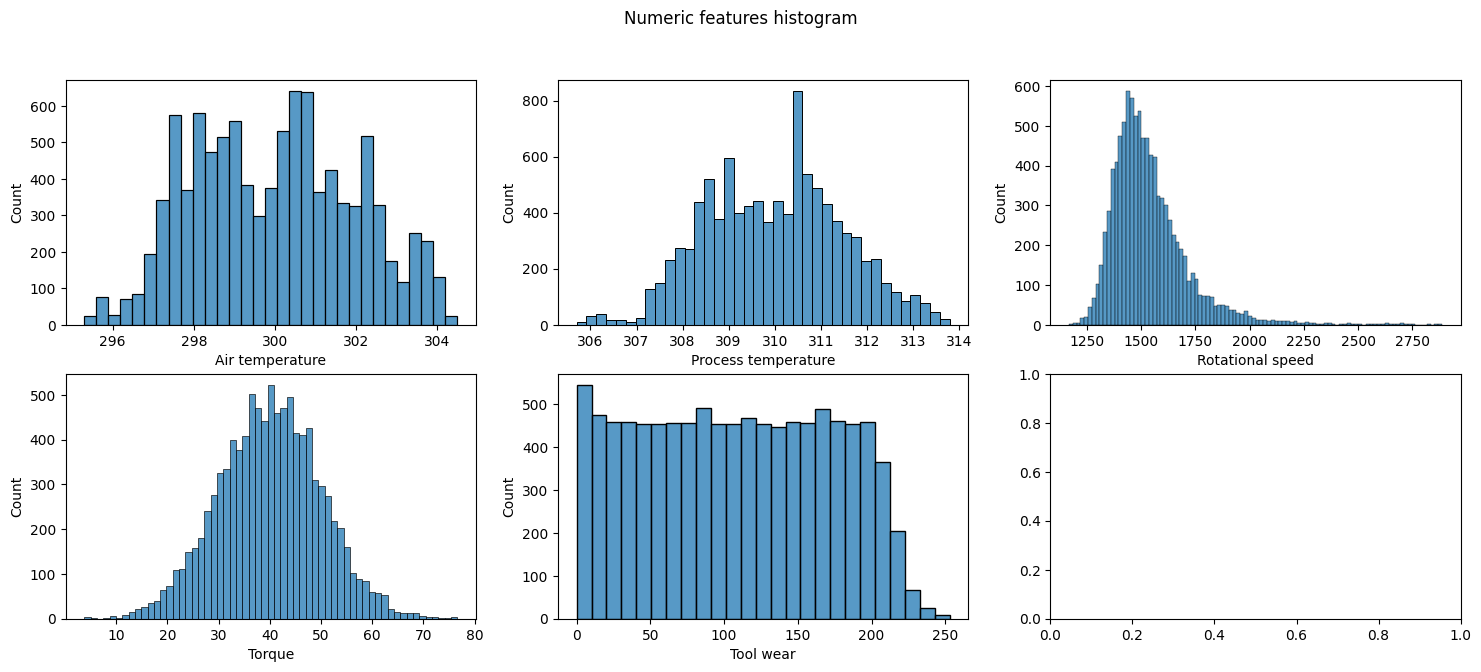

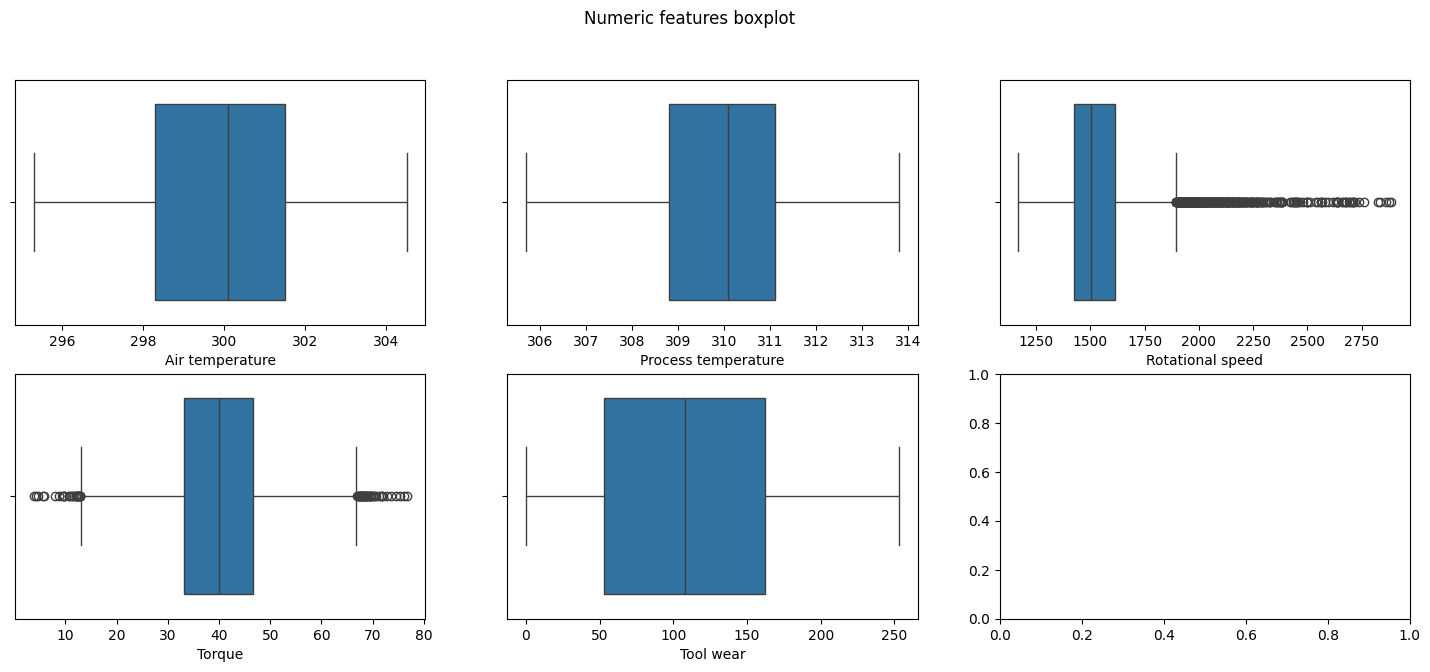

In [13]:
num_features = [feature for feature in features if pm[feature].dtype=='float64']
# Histograms of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features histogram')
for j, feature in enumerate(num_features):
    sns.histplot(ax=axs[j//3, j-3*(j//3)], data=pm, x=feature)
plt.show()

# boxplot of numeric features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,7))
fig.suptitle('Numeric features boxplot')
for j, feature in enumerate(num_features):
    sns.boxplot(ax=axs[j//3, j-3*(j//3)], data=pm, x=feature)
plt.show()

Failures in percentage in the dataset:  3.31


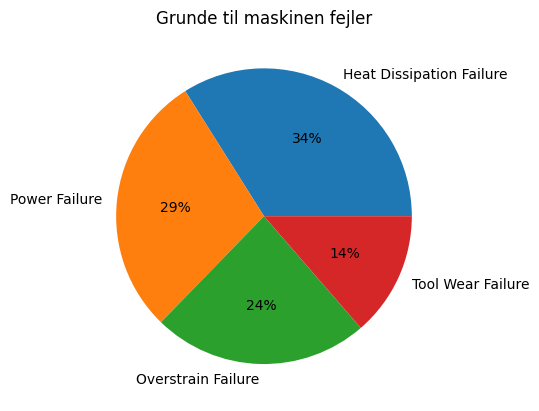

In [14]:
# del af DataFramen som faliure udgør i procent 
idx_fail = pm.loc[pm['Failure Type'] != 'No Failure'].index
pm_fail = pm.loc[idx_fail]
pm_fail_percentage = 100*pm_fail['Failure Type'].value_counts()/pm_fail['Failure Type'].shape[0]
print('Failures in percentage in the dataset: ',
      round(100*pm['Target'].sum()/n,2))

plt.title('Grunde til maskinen fejler')
plt.pie(x=pm_fail_percentage.array, labels=pm_fail_percentage.index.array, 
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

### Resample
This code is using the SMOTENC (Synthetic Minority Over-sampling Technique for Nominal and Continuous features) algorithm from the imblearn library to balance the class distribution in a dataset. The goal is to address the issue of class imbalance, where some classes have significantly more samples than others. In this case, the class with the label 'No Failure' is over-represented compared to the other classes.

Here's a step-by-step explanation of the code:

Import necessary libraries:
- sklearn.model_selection.train_test_split: For splitting the dataset into      training and testing sets.
- imblearn.over_sampling.SMOTENC: For applying the SMOTENC algorithm to balance the class distribution.

- Calculate n_working as the number of 'No Failure' samples in the dataset.
- Calculate desired_length as 80% of n_working.
- Calculate spc as the number of samples to be added to each of the under-represented classes to achieve the desired class distribution.
- Define the balance_cause dictionary, which specifies the number of samples for each class after balancing.
- Initialize the SMOTENC object with the following parameters:
--categorical_features: The indices of the categorical features in the dataset.
sampling_strategy: The desired number of samples for each class, as defined in balance_cause.
- random_state: The seed for the random number generator.
- Fit and resample the dataset using the SMOTENC object, storing the results in pm_res and y_res.

The resulting pm_res and y_res will have a balanced class distribution, which can help improve the performance of machine learning models trained on this data.

In [16]:
# Synthetic Minority Over-sampling Technique for Nominal and Continuous features
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

# n_working skal beskrive mindst 80% ad the beskrevet længde af den nye dataframe
n_working = pm['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #Antal samples fra hver class
# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
pm_res, y_res = sm.fit_resample(pm, pm['Failure Type'])

- idx_fail_res = pm_res.loc[pm_res['Failure Type'] != 'No Failure'].index - This line selects the index of rows in the pm_res DataFrame where the 'Failure Type' is not 'No Failure'.

- pm_res_fails = pm_res.loc[idx_fail_res] - This line creates a new DataFrame pm_res_fails containing only the rows with failure types other than 'No Failure'.

- fail_res_percentage = 100*pm_res_fails['Failure Type'].value_counts()/pm_res_fails.shape[0] - This line calculates the percentage of different failure types in the pm_res_fails DataFrame. It uses the value_counts() method to count the occurrences of each failure type and then calculates the percentage by dividing the count by the total number of rows in pm_res_fails.

- print('Procentvis forøgelse af observationer efter oversampling:', round((pm_res.shape[0]-pm.shape[0])*100/pm.shape[0],2)) - This line calculates and prints the percentage increase in the number of observations after oversampling. It subtracts the original number of observations (pm.shape[0]) from the number of observations after oversampling (pm_res.shape[0]) and then divides the result by the original number of observations, multiplying by 100 to get a percentage.

- print('SMOTE Resampled Failures procent:', round(pm_res_fails.shape[0]*100/pm_res.shape[0],2)) - This line calculates and prints the percentage of failures in the oversampled dataset. It divides the number of failures (pm_res_fails.shape[0]) by the total number of rows in the oversampled dataset (pm_res.shape[0]) and multiplies by 100 to get a percentage.

Procentvis forøgelse af observationer efter oversampling: 20.88
SMOTE Resampled Failures procent: 20.01


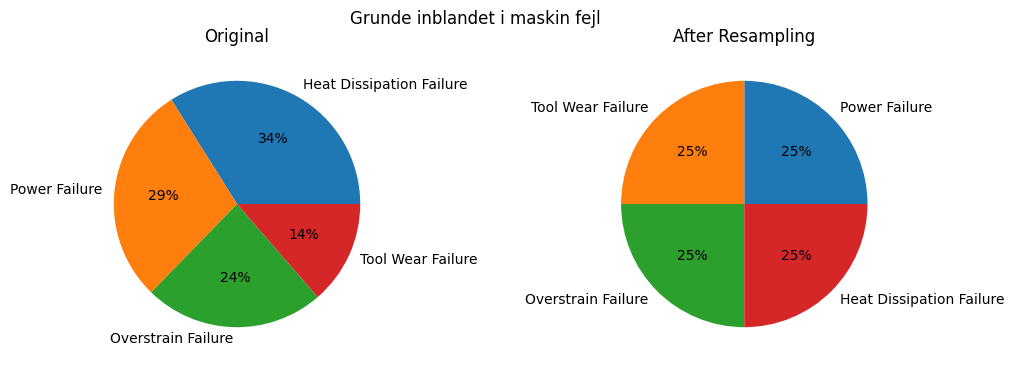

In [17]:
# Del af hvor der er en fejl og årsags procent 
# Res er resample(BAre hvis du glemmer det)
idx_fail_res = pm_res.loc[pm_res['Failure Type'] != 'No Failure'].index
pm_res_fails = pm_res.loc[idx_fail_res]
fail_res_percentage =   100*pm_res_fails['Failure Type'].value_counts()/pm_res_fails.shape[0]

print('Procentvis forøgelse af observationer efter oversampling:', round((pm_res.shape[0]-pm.shape[0])*100/pm.shape[0],2))
print('SMOTE Resampled Failures procent:', round(pm_res_fails.shape[0]*100/pm_res.shape[0],2))

fig, axs = plt.subplots(ncols=2, figsize=(12,4))
fig.suptitle('Grunde inblandet i maskin fejl')


axs[0].pie(x=pm_fail_percentage.array, labels=pm_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier




ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [25]:
X, y = pm[features], pm[['Target', 'Failure Type']]
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=pm['Failure Type'], random_state=0) 
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval['Failure Type'], random_state=0)

In [29]:
def create_model(optimizer='adam', activation='relu', units=64):
    model = Sequential()
    model.add(Dense(4, input_shape=(6,),activation='relu'))
    model.add(Dense(28, activation='relu'))
    model.add(Dense(28, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'activation': ['relu', 'tanh'],
    'units': [32, 64, 128]
}

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 4)                 28        
                                                                 
 dense_15 (Dense)            (None, 28)                140       
                                                                 
 dense_16 (Dense)            (None, 28)                812       
                                                                 
 dense_17 (Dense)            (None, 2)                 58        
                                                                 
Total params: 1038 (4.05 KB)
Trainable params: 1038 (4.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
